In [1]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import sys
from glob import glob
# from keras.preprocessing import image
# from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from tensorflow.keras.preprocessing import image
from keras.utils import plot_model

In [2]:
# Install kaggle
! pip install -q kaggle

In [ ]:
# Upload the kaggle.json file you just downloaded
from google.colab import files
files.upload()

In [ ]:
# Make directory named kaggle 
!mkdir ~/.kaggle

In [ ]:
# Copy kaggle.json file there
! cp kaggle.json ~/.kaggle/

In [ ]:
# Change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
# Download the dataset zip in this location 
DATA_DIR = '../data'
IMAGE_DIR = '../data/images'
!mkdir ../data
!mkdir ../data/face-mask-lite-dataset
!mkdir ../data/images

In [ ]:
# Downloading the dataset from Kaggle
!kaggle datasets download -d prasoonkottarathil/face-mask-lite-dataset -p {DATA_DIR}

100% 23.3G/23.3G [02:51<00:00, 137MB/s]
100% 23.3G/23.3G [02:51<00:00, 145MB/s]


In [ ]:
# Unzipping
shutil.unpack_archive(os.path.join(DATA_DIR,'face-mask-lite-dataset.zip'),DATA_DIR)
os.remove(os.path.join(DATA_DIR,'face-mask-lite-dataset.zip'))
# Changing the data directory to KAGGLE_DIR
KAGGLE_DIR = os.path.join(DATA_DIR, 'face-mask-lite-dataset')

In [ ]:
# Create train, validation, and test directories
split_dirs = ['train', 'validation', 'test']
for split_dir in split_dirs:
    # Create label subdirectories
    label_dirs = ['with_mask', 'without_mask']
    for label_dir in label_dirs:
        new_dir = os.path.join(KAGGLE_DIR, split_dir, label_dir)
        os.makedirs(new_dir, exist_ok=True)

In [ ]:
# Copy dataset images into subdirectories based on probability distribution 'p'
PERCENT_OF_DATA = 0.1
np.random.seed(42)
for folder in os.listdir(DATA_DIR):
  for file in os.listdir(os.path.join(DATA_DIR,folder)):
    if not file.endswith('.png'):
        continue # Skip over non-image files
    src = os.path.join(DATA_DIR, folder, file)
    if np.random.uniform() > PERCENT_OF_DATA:
        os.remove(src)
        continue
    dst_dir = np.random.choice(['train', 'validation', 'test'], p=[.5, .25, .25])
    if file.startswith('with-mask-default-mask'):
        dst = os.path.join(KAGGLE_DIR, dst_dir, 'with_mask', file)
    elif file.startswith('seed'):
        dst = os.path.join(KAGGLE_DIR, dst_dir, 'without_mask', file)
    try:
        shutil.move(src, dst)
    except Exception as e:
        print(e)
# Remove these empty directories
shutil.rmtree(IMAGE_DIR)

In [ ]:
#Number of images in each subdir
for dir_name in split_dirs:
    for label_dir in label_dirs:
        print(dir_name ,label_dir, len(os.listdir(KAGGLE_DIR + '/' + dir_name + '/' + label_dir)))

train with_mask 509
train without_mask 489
validation with_mask 270
validation without_mask 247
test with_mask 255
test without_mask 272


In [ ]:
# Preprocessing the image into a 4D tensor
img_path = glob(KAGGLE_DIR+'/*/*/*.png')[0]

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


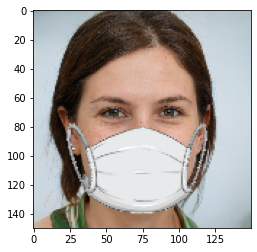

In [ ]:
# Displaying an example img
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# Creating generators
datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
batch_size = 16
target_size = (75, 75)

traingen = datagen.flow_from_directory(directory='/data/face-mask-lite-dataset/train', target_size=target_size, batch_size=batch_size, class_mode='categorical')
 
valgen = datagen.flow_from_directory(directory='/data/face-mask-lite-dataset/validation', target_size=target_size, batch_size=batch_size, class_mode='categorical')

testgen = datagen.flow_from_directory(directory='/data/face-mask-lite-dataset/test', target_size=target_size, batch_size=batch_size, class_mode='categorical')

Found 998 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 527 images belonging to 2 classes.


In [ ]:
print("Class Indices:", traingen.class_indices)

Class Indices: {'with_mask': 0, 'without_mask': 1}


In [ ]:
#Creating a CNN
CNN = Sequential()

CNN.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16, 32, 64]:
    CNN.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN.add(Dense(128, activation='relu'))

#Specify the output layer
CNN.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

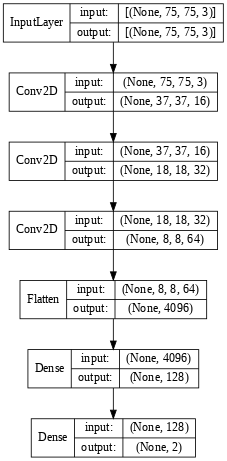

In [ ]:
plot_model(CNN, show_shapes=True, show_layer_names=False, dpi=60)

In [ ]:
# Training the CNN model
history = CNN.fit(traingen,
        epochs=20,
        validation_data=valgen)

Epoch 1/20
63/63 [==============================] - 93s 1s/step - loss: 0.1179 - accuracy: 0.9409 - val_loss: 2.5721e-05 - val_accuracy: 1.0000
Epoch 2/20
63/63 [==============================] - 81s 1s/step - loss: 1.4441e-05 - accuracy: 1.0000 - val_loss: 8.7585e-06 - val_accuracy: 1.0000
Epoch 3/20
63/63 [==============================] - 79s 1s/step - loss: 7.1841e-06 - accuracy: 1.0000 - val_loss: 7.6276e-06 - val_accuracy: 1.0000
Epoch 4/20
63/63 [==============================] - 80s 1s/step - loss: 5.7047e-06 - accuracy: 1.0000 - val_loss: 7.4861e-06 - val_accuracy: 1.0000
Epoch 5/20
63/63 [==============================] - 79s 1s/step - loss: 4.6052e-06 - accuracy: 1.0000 - val_loss: 9.6607e-06 - val_accuracy: 1.0000
Epoch 6/20
63/63 [==============================] - 80s 1s/step - loss: 4.6780e-06 - accuracy: 1.0000 - val_loss: 7.5913e-06 - val_accuracy: 1.0000
Epoch 7/20
63/63 [==============================] - 79s 1s/step - loss: 3.2959e-06 - accuracy: 1.0000 - val_loss: 4.

In [ ]:
CNN.evaluate(testgen)

33/33 [==============================] - 32s 966ms/step - loss: 1.0031e-06 - accuracy: 1.0000


[1.0030844350694679e-06, 1.0]

Text(0.5, 1.0, 'Accuracy Plot')

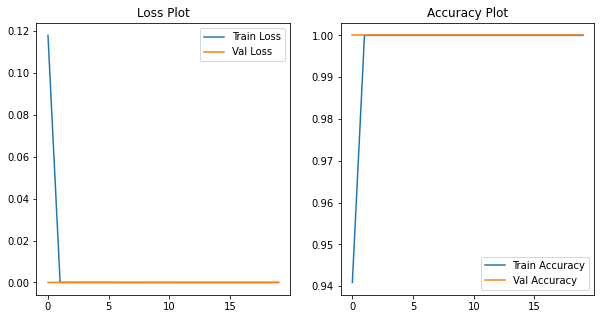

In [ ]:
# Plotting the loss and accuracy plots
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history.history['loss'], label="Train Loss")
ax[0].plot(history.history['val_loss'], label="Val Loss")
ax[1].plot(history.history['accuracy'], label="Train Accuracy")
ax[1].plot(history.history['val_accuracy'], label="Val Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Loss Plot")
ax[1].set_title("Accuracy Plot")

In [ ]:
# Augmenting the data using ImageDataGenerator
datagen_aug = ImageDataGenerator(rotation_range=180,
                                 width_shift_range=.1, height_shift_range=.1,
                                 rescale=1/255,
                                 zoom_range=.2,
                                 horizontal_flip=True)
traingen_aug = datagen_aug.flow_from_directory("/data/face-mask-lite-dataset/train", target_size=target_size,
                                               class_mode='categorical', batch_size=32)

Found 998 images belonging to 2 classes.


In [ ]:
os.listdir('../data/face-mask-lite-dataset/train/without_mask/')

['seed0200.png',
 'seed0206.png',
 'seed7633.png',
 'seed2034.png',
 'seed9929.png',
 'seed5425.png',
 'seed7686.png',
 'seed4310.png',
 'seed2396.png',
 'seed2576.png',
 'seed5307.png',
 'seed0499.png',
 'seed5599.png',
 'seed1877.png',
 'seed4517.png',
 'seed3701.png',
 'seed4879.png',
 'seed3158.png',
 'seed7395.png',
 'seed0651.png',
 'seed6511.png',
 'seed3938.png',
 'seed2995.png',
 'seed7255.png',
 'seed0854.png',
 'seed8805.png',
 'seed2178.png',
 'seed1605.png',
 'seed4612.png',
 'seed9080.png',
 'seed4342.png',
 'seed8091.png',
 'seed2254.png',
 'seed7264.png',
 'seed2358.png',
 'seed6392.png',
 'seed2733.png',
 'seed7001.png',
 'seed1608.png',
 'seed5327.png',
 'seed5366.png',
 'seed6631.png',
 'seed5631.png',
 'seed0869.png',
 'seed5215.png',
 'seed1589.png',
 'seed9430.png',
 'seed3206.png',
 'seed4680.png',
 'seed4782.png',
 'seed9699.png',
 'seed7231.png',
 'seed3767.png',
 'seed3363.png',
 'seed4448.png',
 'seed4739.png',
 'seed5164.png',
 'seed5736.png',
 'seed6478.png

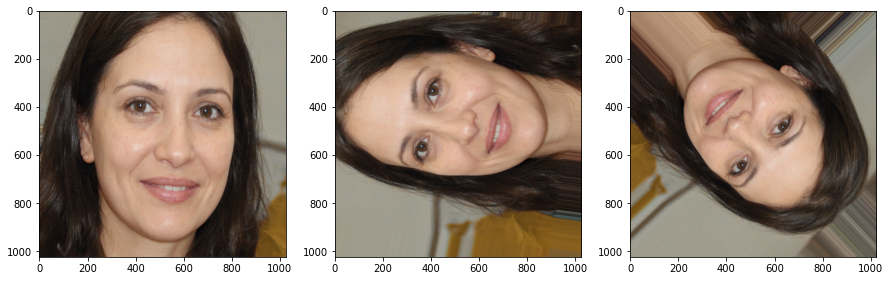

In [ ]:
# Looking at the data
img = image.load_img('/data/face-mask-lite-dataset/train/without_mask/seed9497.png')
img = image.img_to_array(img)
img = np.array([img])
aug_iter = datagen_aug.flow(img, batch_size=1)
fig, ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
  img_aug= next(aug_iter)[0]
  ax[i].imshow(img_aug)

In [ ]:
#Creating a CNN
CNN_aug = Sequential()

CNN_aug.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16,32, 64]:
    CNN_aug.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN_aug.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN_aug.add(Dense(128, activation='relu'))

#Specify the output layer
CNN_aug.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN_aug.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

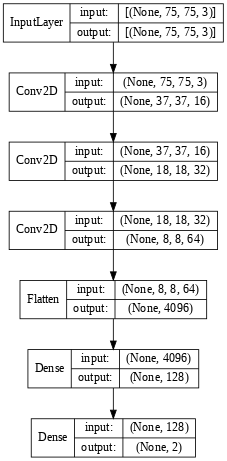

In [ ]:
plot_model(CNN_aug, show_shapes=True, show_layer_names=False, dpi=60)

In [ ]:
# Training the model
history_aug = CNN_aug.fit(traingen_aug,
        epochs=20,
        validation_data=valgen)

Epoch 1/20
32/32 [==============================] - 83s 3s/step - loss: 0.6407 - accuracy: 0.6383 - val_loss: 0.4204 - val_accuracy: 0.8665
Epoch 2/20
32/32 [==============================] - 80s 3s/step - loss: 0.2130 - accuracy: 0.9339 - val_loss: 0.0283 - val_accuracy: 0.9981
Epoch 3/20
32/32 [==============================] - 79s 3s/step - loss: 0.0727 - accuracy: 0.9840 - val_loss: 0.0090 - val_accuracy: 0.9981
Epoch 4/20
32/32 [==============================] - 79s 2s/step - loss: 0.0477 - accuracy: 0.9860 - val_loss: 0.0138 - val_accuracy: 0.9942
Epoch 5/20
32/32 [==============================] - 80s 3s/step - loss: 0.0355 - accuracy: 0.9930 - val_loss: 0.0085 - val_accuracy: 0.9961
Epoch 6/20
32/32 [==============================] - 80s 3s/step - loss: 0.0317 - accuracy: 0.9910 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 7/20
32/32 [==============================] - 80s 3s/step - loss: 0.0563 - accuracy: 0.9780 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 8/20
32/32 [==

Text(0.5, 1.0, 'Accuracy Plot')

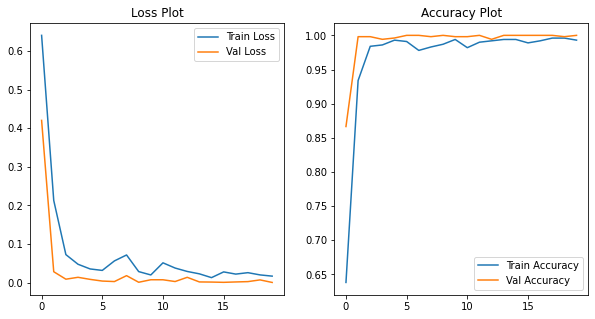

In [ ]:
# Plotting the loss and accuracy plots
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history_aug.history['loss'], label="Train Loss")
ax[0].plot(history_aug.history['val_loss'], label="Val Loss")
ax[1].plot(history_aug.history['accuracy'], label="Train Accuracy")
ax[1].plot(history_aug.history['val_accuracy'], label="Val Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Loss Plot")
ax[1].set_title("Accuracy Plot")

In [ ]:
CNN_aug.evaluate(testgen, steps=650/batch_size)

33/40 [=======================>......] - ETA: 6s - loss: 6.7253e-04 - accuracy: 1.0000

40/40 [==============================] - 29s 715ms/step - loss: 6.7253e-04 - accuracy: 1.0000


[0.0006725310813635588, 1.0]

In [ ]:
CNN_aug.save_weights('model_weights.h5')

NameError: ignored

In [ ]:
CNN_aug_new = Sequential()

CNN_aug_new.add(Input(shape=(75, 75, 3)))

#Specify a list of the number of filters for each convolutional layer

for n_filters in [16,32, 64]:
    CNN_aug_new.add(Conv2D(n_filters,strides=(2, 2), kernel_size=3, activation='relu'))

# Fill in the layer needed between our 2d convolutional layers and the dense layer
CNN_aug_new.add(Flatten())

#Specify the number of nodes in the dense layer before the output
CNN_aug_new.add(Dense(128, activation='relu'))

#Specify the output layer
CNN_aug_new.add(Dense(2, activation='softmax'))
 
#Compiling the model
CNN_aug_new.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
CNN_aug_new.load_weights('/content/sample_data/model_weights.h5')

In [ ]:
img = image.load_img('/content/sample_data/test/14.jpg',target_size=(75, 75))
img = image.img_to_array(img)
img = np.array([img])
aug_iter = datagen.flow(img, batch_size=1)
prediction=CNN_aug_new.predict(img)
prediction

1/1 [==============================] - 0s 67ms/step


array([[1., 0.]], dtype=float32)

Text(0.5, 1.0, 'with-mask')

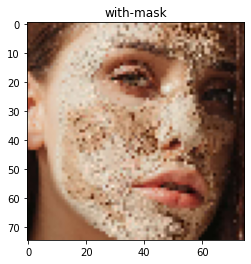

In [ ]:
img = image.load_img('/content/sample_data/test/14.jpg',target_size=(75, 75))
plt.imshow(img)
#tells label of the image
plt.title('with-mask' if np.argmax(prediction)==0 else "without-mask")